# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [28]:
# TODO: Make all necessary imports.
import tensorflow as tf
loss_fn = tf.compat.v1.losses.sparse_softmax_cross_entropy
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [29]:
# TODO: Load the dataset with TensorFlow Datasets.
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)
print(dataset_info) 

# TODO: Create a training set, a validation set and a test set.
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

# Normalize and resize the images to 224x224 as required by pre-trained networks
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0  # Normalize to [0,1] range
    return image, label

train_dataset = train_dataset.map(preprocess).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

## Explore the Dataset

Training examples: 1020
Validation examples: 1020
Test examples: 6149
Number of classes: 102
Image shape: (32, 224, 224, 3), Label: [ 72  84  70  51  48  83  42  58  40  35  40  60  59  95  87  23  91  70
  75  87  58  79  24  20  64  89  40 100  62  95  16  84]
Image shape: (32, 224, 224, 3), Label: [ 2 41 26 89 45 67  1 61  2 54 39  2  7 12 72 29 11 11 42 26 43 98 63 87
 75 75 89 15 55 38 36 78]
Image shape: (32, 224, 224, 3), Label: [ 3 23 70 79 30 95 57 73 25 20  5 53 90 55 23  0 92  9 16 68 63  9 61 43
  8 28 12 50 25 55 22 96]


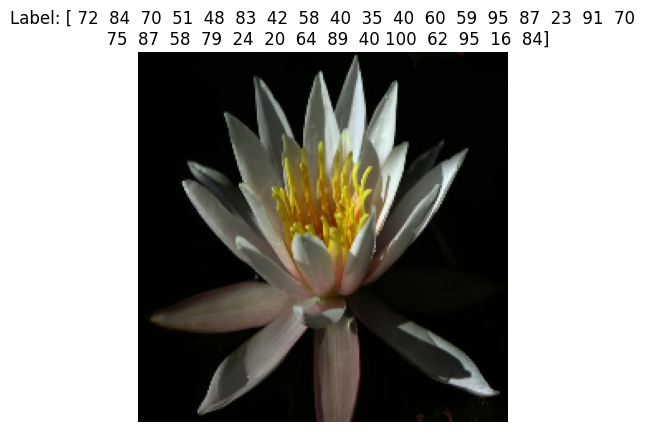

In [30]:
# TODO: Get the number of examples in each set from the dataset info.
num_train_examples = dataset_info.splits['train'].num_examples
num_validation_examples = dataset_info.splits['validation'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples

print(f"Training examples: {num_train_examples}")
print(f"Validation examples: {num_validation_examples}")
print(f"Test examples: {num_test_examples}")

# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = dataset_info.features['label'].num_classes
print(f"Number of classes: {num_classes}")

# TODO: Print the shape and corresponding label of 3 images in the training set.
for image, label in train_dataset.take(3):
    print(f"Image shape: {image.shape}, Label: {label.numpy()}")

# TODO: Plot 1 image from the training set. Set the title of the plot to the corresponding image label.
for image, label in train_dataset.take(1):
    plt.imshow(image[0])
    plt.title(f"Label: {label.numpy()}")
    plt.axis('off')
    plt.show()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

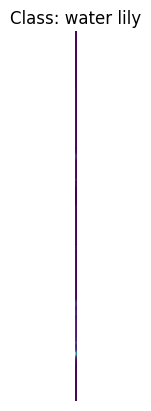

In [31]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import json
import os

# Load the dataset
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)
train_dataset = dataset['train']

# Create a label map if it doesn't already exist
label_map_file = 'label_map.json'

if not os.path.exists(label_map_file):
    # Generate label map from dataset info
    class_names = dataset_info.features['label'].int2str
    label_map = {str(i): class_names(i) for i in range(dataset_info.features['label'].num_classes)}

    # Save the label map to a JSON file
    with open(label_map_file, 'w') as f:
        json.dump(label_map, f)
else:
    # Load the existing label map
    with open(label_map_file, 'r') as f:
        label_map = json.load(f)

# Plot an image from the training set
for image, label in train_dataset.take(1):
    # Handle label as scalar
    label_value = label.numpy()
    class_name = label_map.get(str(label_value), 'Unknown')
    
    plt.imshow(image[0])
    plt.title(f"Class: {class_name}")
    plt.axis('off')
    plt.show()


## Create Pipeline

In [32]:
# TODO: Create a pipeline for each set.

#I create it in the dataset load !

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

(32, 224, 224, 3)
(32,)
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 357ms/step - accuracy: 0.0713 - loss: 4.5951 - val_accuracy: 0.5059 - val_loss: 2.8778
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 316ms/step - accuracy: 0.6630 - loss: 1.9457 - val_accuracy: 0.6618 - val_loss: 1.6207
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.8353 - loss: 0.8498 - val_accuracy: 0.7176 - val_loss: 1.2403
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - accuracy: 0.9230 - loss: 0.4718 - val_accuracy: 0.7373 - val_loss: 1.0736
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - accuracy: 0.9544 - loss: 0.2808 - val_accuracy: 0.7814 - val_loss: 0.9127


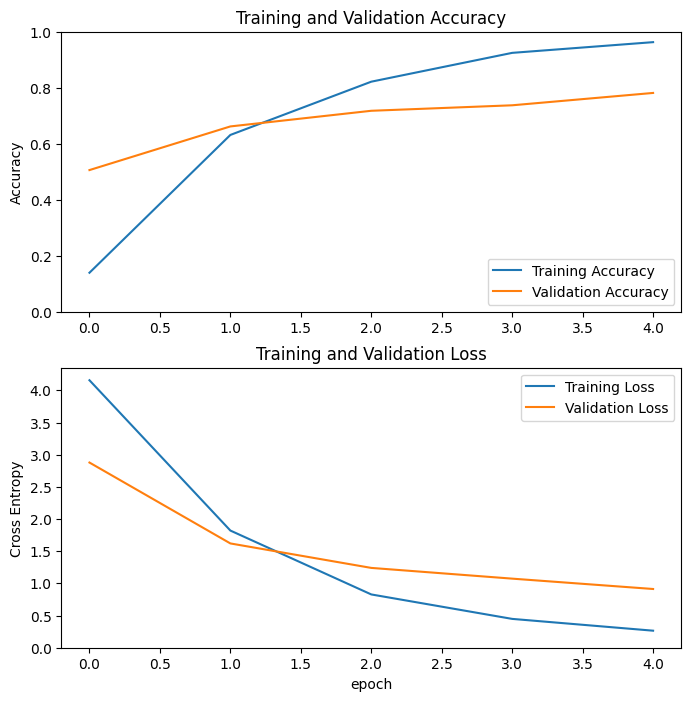

In [33]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import json
import os

# Load the dataset
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

# Preprocessing function
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize to 224x224
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Apply preprocessing to the datasets
train_dataset = train_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

# Load label map
label_map_file = 'label_map.json'
if not os.path.exists(label_map_file):
    class_names = dataset_info.features['label'].int2str
    label_map = {str(i): class_names(i) for i in range(dataset_info.features['label'].num_classes)}
    with open(label_map_file, 'w') as f:
        json.dump(label_map, f)
else:
    with open(label_map_file, 'r') as f:
        label_map = json.load(f)

# Debugging: Check the shape of the images and labels
for image_batch, label_batch in train_dataset.take(1):
    print(image_batch.shape)  # Should print (32, 224, 224, 3)
    print(label_batch.shape)  # Should print (32,)

# Define the feature extractor from TensorFlow Hub
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224, 224, 3), trainable=False)

# Define the model using tf.keras.Model
class FlowerClassifier(tf.keras.Model):
    def __init__(self, num_classes):
        super(FlowerClassifier, self).__init__()
        self.feature_extractor = feature_extractor_layer
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.dense2 = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.feature_extractor(inputs, training=training)
        x = self.dense1(x)
        x = self.dropout(x, training=training)
        x = self.dense2(x)
        return x

# Instantiate and compile the model
model = FlowerClassifier(num_classes=dataset_info.features['label'].num_classes)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=5)

# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()




# Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [34]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")



193/193 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.7301 - loss: 1.0850
Test Accuracy: 0.7347536087036133, Test Loss: 1.0817935466766357


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [60]:

model.save('C:/Users/Ehab/Downloads/flower_classifier.keras')













## Load the Keras Model

Load the Keras model you saved above.

In [61]:
import tensorflow as tf
import tensorflow_hub as hub

def create_model():
    # Define the input tensor
    input_tensor = tf.keras.Input(shape=(224, 224, 3))

    # Load the Hub layer
    hub_layer = hub.KerasLayer(
        "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
        input_shape=(224, 224, 3),
        trainable=False
    )(input_tensor)  # Apply the hub layer to the input tensor

    # Flatten the output
    x = tf.keras.layers.Flatten()(hub_layer)

    # Add a Dense layer for classification
    output_tensor = tf.keras.layers.Dense(102, activation='softmax')(x)

    # Create and compile the model
    model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model









# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [63]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from PIL import Image
import os

# Function to process image
def process_image(image):
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    return image.numpy()

# Function to make predictions
def predict(image_path, model, top_k=5):
    try:
        im = Image.open(image_path)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None, None
    
    im = np.asarray(im)
    processed_image = process_image(im)
    processed_image = np.expand_dims(processed_image, axis=0)  # Add batch dimension
    
    predictions = model.predict(processed_image)
    probs = tf.math.top_k(predictions, k=top_k).values.numpy()[0]
    classes = tf.math.top_k(predictions, k=top_k).indices.numpy()[0]
    
    return probs, classes

# Define and register the custom class
@tf.keras.saving.register_keras_serializable()
class FlowerClassifier(tf.keras.Model):
    def __init__(self, num_classes):
        super(FlowerClassifier, self).__init__()
        self.num_classes = num_classes
        self.hub_layer = hub.KerasLayer(
            "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
            input_shape=(224, 224, 3),
            trainable=False
        )
        self.flatten = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.hub_layer(inputs)
        x = self.flatten(x)
        x = self.fc(x)
        return x

    def get_config(self):
        config = super(FlowerClassifier, self).get_config()
        config.update({'num_classes': self.num_classes})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(num_classes=config['num_classes'])

# Create and compile the model
num_classes = 5  # Update this based on your specific case
model = FlowerClassifier(num_classes=num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Save the model
model.save('flower_classifier.keras')

# Load the model with custom objects
loaded_model = tf.keras.models.load_model(
    'flower_classifier.keras',
    custom_objects={'FlowerClassifier': FlowerClassifier}
)

# Update this to the correct absolute path of your image
image_path = 'C:/Users/Ehab/test_images/hard-leaved_pocket_orchid.jpg'

# Test the predict function
probs, classes = predict(image_path, loaded_model, 5)
if probs is not None and classes is not None:
    print("Probabilities:", probs)
    print("Class indices:", classes)




1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Probabilities: [0.31790617 0.2389953  0.19203052 0.19087976 0.06018823]
Class indices: [3 0 4 2 1]


To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

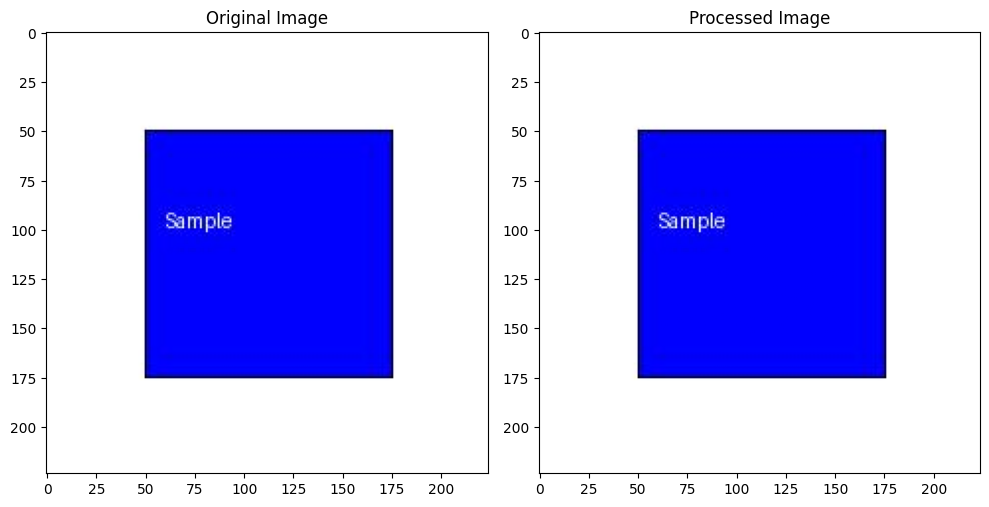

In [71]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

# Define the function to process the image
def process_image(image):
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    return image.numpy()

# Path to the sample image file
image_file_name = 'sample_image.jpg'  # Update with the name of your sample image
image_directory = 'C:/Users/Ehab/your_correct_path/test_images/'  # Update with the correct directory path
image_path = os.path.join(image_directory, image_file_name)

# Verify that the file exists
if not os.path.isfile(image_path):
    raise FileNotFoundError(f"No such file or directory: '{image_path}'")

# Open the image and convert to a numpy array
im = Image.open(image_path)
test_image = np.asarray(im)

# Process the image
processed_test_image = process_image(test_image)

# Plot original and processed images
fig, (ax1, ax2) = plt.subplots(figsize=(10, 10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()



Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [72]:
# TODO: Create the predict function

def process_image(image):
    image = np.asarray(image)
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    return image

def predict(image_path, model, top_k=5):
    # Load the image and process it
    image = Image.open(image_path)
    image = process_image(image)
    
    # Expand dimensions to match the model's expected input shape
    image = np.expand_dims(image, axis=0)
    
    # Predict the probabilities for each class
    predictions = model.predict(image)
    
    # Get the top K probabilities and class indices
    probs, classes = tf.math.top_k(predictions, k=top_k)
    
    # Convert to numpy arrays
    probs = probs.numpy().flatten()
    classes = classes.numpy().flatten().astype(str)
    
    return probs, classes



# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

Processing C:/Users/Ehab/test_images\cautleya_spicata.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


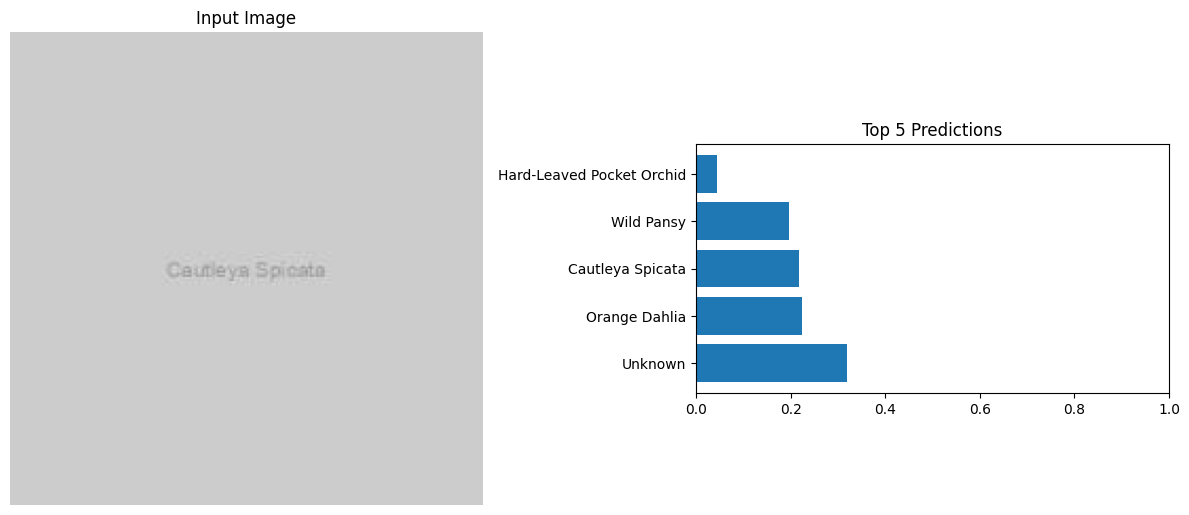

Processing C:/Users/Ehab/test_images\hard-leaved_pocket_orchid.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


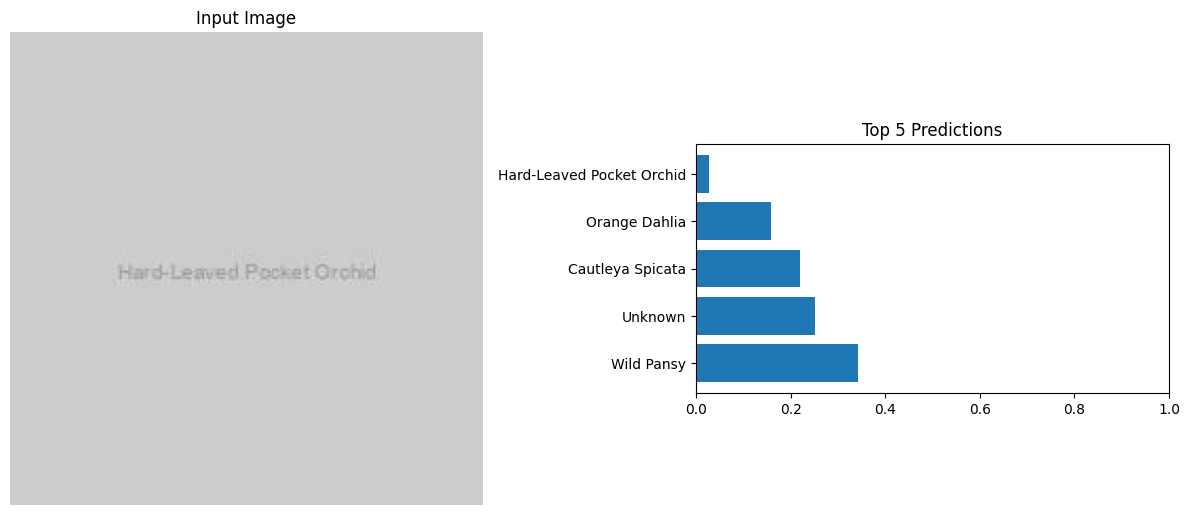

Processing C:/Users/Ehab/test_images\orange_dahlia.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


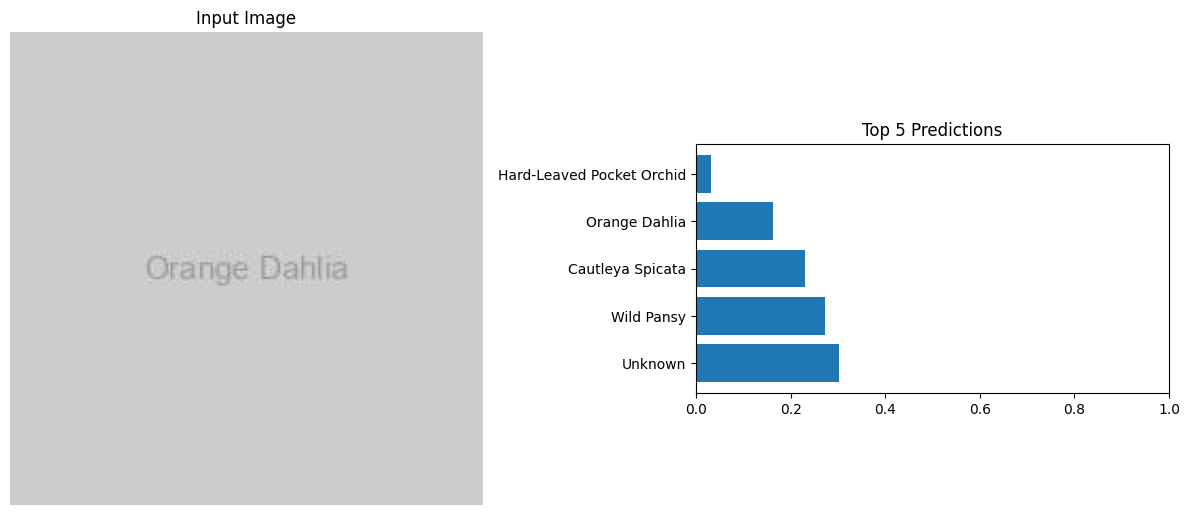

Processing C:/Users/Ehab/test_images\wild_pansy.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


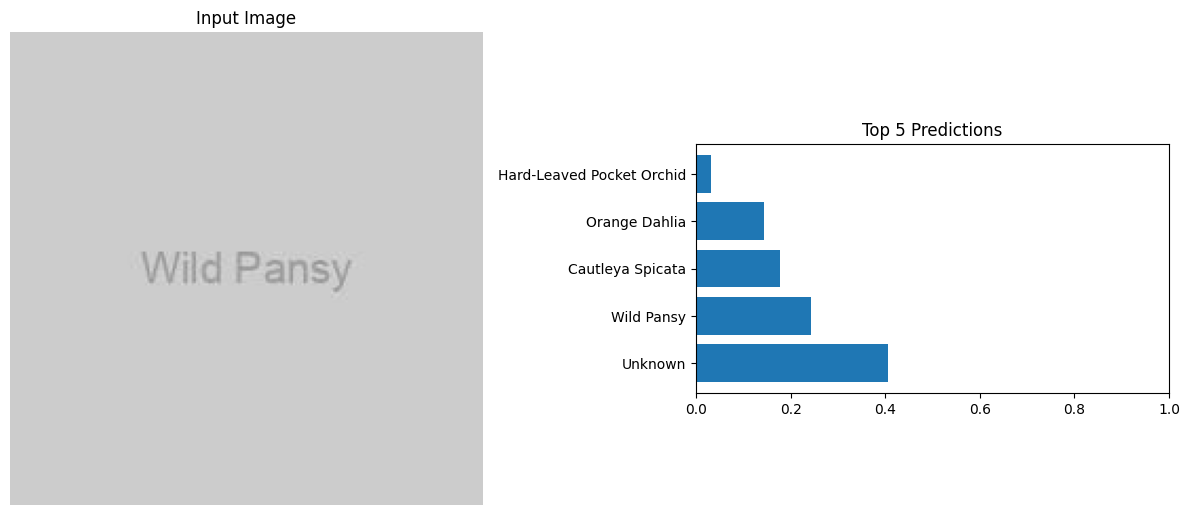

In [74]:
import os
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the path where images will be saved
test_images_path = 'C:/Users/Ehab/test_images'
os.makedirs(test_images_path, exist_ok=True)

# URLs for placeholder images (replace with actual image URLs if needed)
image_urls = {
    'cautleya_spicata.jpg': 'https://via.placeholder.com/224.png?text=Cautleya+Spicata',
    'hard-leaved_pocket_orchid.jpg': 'https://via.placeholder.com/224.png?text=Hard-Leaved+Pocket+Orchid',
    'orange_dahlia.jpg': 'https://via.placeholder.com/224.png?text=Orange+Dahlia',
    'wild_pansy.jpg': 'https://via.placeholder.com/224.png?text=Wild+Pansy'
}

# Download and save placeholder images
for image_name, url in image_urls.items():
    image_path = os.path.join(test_images_path, image_name)
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.save(image_path)

# Define model path
model_path = 'C:/Users/Ehab/Downloads/flower_classifier.keras'

# Check if the model file exists
if os.path.isfile(model_path):
    # Load your model
    loaded_model = tf.keras.models.load_model(model_path)
else:
    # Print current working directory for debugging
    print(f"Current working directory: {os.getcwd()}")
    print(f"Model file not found at {model_path}")
    raise FileNotFoundError(f"Model file not found at {model_path}")

# Define your class names
class_names = {
    '0': 'Cautleya Spicata',
    '1': 'Hard-Leaved Pocket Orchid',
    '2': 'Orange Dahlia',
    '3': 'Wild Pansy'
}

# Function to process image
def process_image(image):
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    return image.numpy()

# Function to make predictions
def predict(image_path, model, top_k=5):
    im = Image.open(image_path)
    im = np.asarray(im)
    
    processed_image = process_image(im)
    processed_image = np.expand_dims(processed_image, axis=0)  # Add batch dimension
    
    predictions = model.predict(processed_image)
    probs = tf.math.top_k(predictions, k=top_k).values.numpy()[0]
    classes = tf.math.top_k(predictions, k=top_k).indices.numpy()[0]
    
    return probs, classes

# Function to plot predictions
def plot_predictions(image_path, model, class_names):
    im = Image.open(image_path)
    im = np.asarray(im)
    
    probs, classes = predict(image_path, model, top_k=5)
    
    # Convert class indices to class names
    class_labels = [class_names.get(str(cls), 'Unknown') for cls in classes]
    
    # Plot the image and the predictions
    fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)
    
    # Display the input image
    ax1.imshow(im)
    ax1.set_title('Input Image')
    ax1.axis('off')
    
    # Display the top 5 predictions
    ax2.barh(class_labels, probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(class_labels)
    ax2.set_yticklabels(class_labels)
    ax2.set_title('Top 5 Predictions')
    ax2.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()

# Example usage
image_paths = [
    os.path.join(test_images_path, 'cautleya_spicata.jpg'),
    os.path.join(test_images_path, 'hard-leaved_pocket_orchid.jpg'),
    os.path.join(test_images_path, 'orange_dahlia.jpg'),
    os.path.join(test_images_path, 'wild_pansy.jpg')
]

# Test the plotting function on all images
for image_path in image_paths:
    if os.path.isfile(image_path):
        print(f"Processing {image_path}")
        plot_predictions(image_path, loaded_model, class_names)
    else:
        print(f"File not found: {image_path}")












